In [1]:
import re
import os
import json
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from sklearn.linear_model import RidgeCV
from soynlp.normalizer import only_hangle
from soynlp.noun import LRNounExtractor_v2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, f1_score, classification_report

# 1. 훈련, 테스트 데이터셋 분할

In [2]:
regression_data = pd.read_csv("ml_data/regression_data.csv", encoding="utf-8")
X_regression, y_regression = regression_data["infotext"], regression_data.drop("infotext", axis=1)
regression_label_column = y_regression.columns
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size=0.2, random_state=20251115)

In [3]:
classification_data = pd.read_csv("ml_data/classification_data_manual.csv", encoding="utf-8")
X_classification, y_classification = classification_data["infotext"], classification_data.drop("infotext", axis=1)
classification_label_column = y_classification.columns
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X_classification, y_classification, test_size=0.2, random_state=20251115)

# 2. 전처리

In [4]:
tag_vocab = {
	"activity": {
		"strong": {
			"거리공연", "길놀이", "놀이터", "눈썰매", "드론", "드론쇼", "마임", "물놀이", "민속놀이", "불꽃놀이",
            "빙어낚시", "산책", "쇼", "썰매", "아트마켓", "얼음썰매", "요가", "윷놀이", "참여프로그램",
            "랜덤플레이댄스", "체험", "체험부스", "체험존", "체험프로그램", "체험행사", "춤", "카약", "캠핑", "탐방",
            "투어", "파티", "퍼레이드", "풀장", "프리마켓", "플래시몹", "플리마켓", "참여형",
		},
		"weak": {
			"개막공연", "개막행사", "게임", "경연", "공모전", "공방", "부대행사", "사생대회", "스탬프",
            "시식", "시연", "시음", "연출", "워크숍", "즐길거리", "참가", "챌린지", "체험장", "초청공연",
            "촬영", "축하공연", "출연", "콘테스트", "토크쇼", "특별공연", "패션쇼", "포토존", "피크닉", "피크닉존", "야시장",
		}
	},
	"children": {
		"strong": {
			"가족", "가족단위", "그림책", "놀이터", "눈썰매", "도서관", "민속놀이", "아이들", "어린이", "어린이날",
            "얼음썰매", "윷놀이", "청소년", "피크닉", "피크닉존"
		},
		"weak": {
			"가정", "꿈", "나들이", "놀이", "인생네컷", "책", "키링"
		}
	},
	"culture": {
		"strong": {
			"공연", "공예", "공예품", "국가유산", "군악대", "궁중", "그림책", "노래", "노래자랑",
            "다문화", "달집태우기", "도서관", "독서", "마임", "무형유산", "문학", "문화", "문화공연", "문화관광축제",
            "문화예술", "문화예술공연", "문화유산", "문화제", "문화체험", "문화축제", "문화행사", "뮤지션", "뮤지컬", "민속놀이",
			"박물관", "밴드", "버스킹", "버스킹공연", "세계유산", "소리", "아리랑", "역사", "예술", "예술인",
            "오케스트라", "왕실", "웹툰", "유네스코", "재즈", "전시관", "전시회", "전통", "전통놀이", "전통문화",
            "정월대보름", "조선시대", "지역예술인", "책", "춤", "캘리그라피", "콘서트", "크리스마스", "클래식", "트로트",
            "판소리", "한글", "한복", "합창단", "힙합", "농악",
		},
		"weak": {
			"그림", "근대", "도깨비", "문화적", "미디어", "사생대회", "사진", "시간여행", "아티스트", "역사적",
            "영상", "예술적", "작품", "정취", "출판사", "트리", "향수", "향연", "전통주"
		}
	},
	"food": {
		"strong": {
			"간식", "건어물", "고구마", "고등어", "고로쇠", "곶감", "김밥", "농산물", "농특산물", "디저트",
            "딸기", "로컬푸드", "막걸리", "맛", "맛집", "맥주", "먹거리", "먹거리부스", "미식", "바지락",
			"분식", "비빔밥", "수산물", "수제맥주", "야시장", "요리", "음료", "음식", "장어", "전통주",
            "치즈", "커피", "토마토", "특산물", "특산품", "푸드존", "푸드트럭", "푸드트럭존", "한우"
		},
		"weak": {
			"달콤", "마켓", "상품", "장터", "저잣거리", "전통시장", "카페"
		}
	},
	"nature": {
		"strong": {
			"가을꽃", "갯골", "갯벌", "공원", "꽃", "나비", "무궁화", "보리밭", "산", "산수유",
            "산책", "산책길", "생태", "수국", "수선화", "숲", "억새", "유채꽃", "자연", "자연경관",
            "정원", "풍경", "해변", "국화"
		},
		"weak": {
			"나들이", "노을", "물결", "물놀이", "빙어낚시", "웰니스", "잔디광장", "친환경", "하늘"
		}
	},
	"night": {
		"strong": {
			"경관조명", "달집태우기", "드론쇼", "라이트쇼", "밤", "별", "별빛", "불꽃", "불꽃놀이", "불꽃쇼",
            "야간경관", "야경", "야시장", "야행", "유등", "전야제", "정월대보름", "미디어파사드", "파사드",
		},
		"weak": {
			"달빛", "라이트", "야간", "저녁", "점등식"
		}
	},
	"season": {
		"strong": {
			"가을", "가을꽃", "겨울", "겨울철", "계절", "단오", "벚꽃", "봄", "봄꽃", "봄날",
            "새해", "여름", "유채꽃", "정월대보름", "크리스마스", "풍년"
		},
		"weak": {
			"딸기", "어린이날", "얼음썰매"
		}
	}
}

vocabulary = {noun for strength in tag_vocab.values() for strength_noun in strength.values() for noun in strength_noun}
vocabulary

{'가을',
 '가을꽃',
 '가정',
 '가족',
 '가족단위',
 '간식',
 '개막공연',
 '개막행사',
 '갯골',
 '갯벌',
 '거리공연',
 '건어물',
 '게임',
 '겨울',
 '겨울철',
 '경관조명',
 '경연',
 '계절',
 '고구마',
 '고등어',
 '고로쇠',
 '공모전',
 '공방',
 '공연',
 '공예',
 '공예품',
 '공원',
 '곶감',
 '국가유산',
 '국화',
 '군악대',
 '궁중',
 '그림',
 '그림책',
 '근대',
 '길놀이',
 '김밥',
 '꽃',
 '꿈',
 '나들이',
 '나비',
 '노래',
 '노래자랑',
 '노을',
 '놀이',
 '놀이터',
 '농산물',
 '농악',
 '농특산물',
 '눈썰매',
 '다문화',
 '단오',
 '달빛',
 '달집태우기',
 '달콤',
 '도깨비',
 '도서관',
 '독서',
 '드론',
 '드론쇼',
 '디저트',
 '딸기',
 '라이트',
 '라이트쇼',
 '랜덤플레이댄스',
 '로컬푸드',
 '마임',
 '마켓',
 '막걸리',
 '맛',
 '맛집',
 '맥주',
 '먹거리',
 '먹거리부스',
 '무궁화',
 '무형유산',
 '문학',
 '문화',
 '문화공연',
 '문화관광축제',
 '문화예술',
 '문화예술공연',
 '문화유산',
 '문화적',
 '문화제',
 '문화체험',
 '문화축제',
 '문화행사',
 '물결',
 '물놀이',
 '뮤지션',
 '뮤지컬',
 '미디어',
 '미디어파사드',
 '미식',
 '민속놀이',
 '바지락',
 '박물관',
 '밤',
 '밴드',
 '버스킹',
 '버스킹공연',
 '벚꽃',
 '별',
 '별빛',
 '보리밭',
 '봄',
 '봄꽃',
 '봄날',
 '부대행사',
 '분식',
 '불꽃',
 '불꽃놀이',
 '불꽃쇼',
 '비빔밥',
 '빙어낚시',
 '사생대회',
 '사진',
 '산',
 '산수유',
 '산책',
 '산책길',
 '상품',
 '새해',
 '생태',
 '세계유산',
 '소리',
 '쇼',
 '

In [5]:
def clean_text(text: str) -> str:
    text = re.sub(r"\d{4}\s*년", " ", text)
    text = re.sub(r"\d+\s*월", " ", text)
    text = re.sub(r"\d+\s*일", " ", text)
    text = re.sub(r"\d+\s*일간", " ", text)
    text = re.sub(r"\d+\s*박\s*\d+\s*일", " ", text)
    text = re.sub(r"\d+\s*시", " ", text)
    text = re.sub(r"\d+\s*분", " ", text)
    text = re.sub(r"\d+\s*초", " ", text)
    text = re.sub(r"\d+\s*주년", " ", text)
    text = re.sub(r"\d+\s*회", " ", text)
    text = re.sub(r"\d+\s*차", " ", text)
    text = re.sub(r"\d+\s*명", " ", text)
    text = only_hangle(text)
    return text

def clean_text_model(text: str) -> str:
    text = re.sub(r"\d{4}\s*년", " ", text)
    text = re.sub(r"\d+\s*월", " ", text)
    text = re.sub(r"\d+\s*일", " ", text)
    text = re.sub(r"\d+\s*일간", " ", text)
    text = re.sub(r"\d+\s*박\s*\d+\s*일", " ", text)
    text = re.sub(r"\d+\s*시", " ", text)
    text = re.sub(r"\d+\s*분", " ", text)
    text = re.sub(r"\d+\s*초", " ", text)
    text = re.sub(r"\d+\s*주년", " ", text)
    text = re.sub(r"\d+\s*회", " ", text)
    text = re.sub(r"\d+\s*차", " ", text)
    text = re.sub(r"\d+\s*명", " ", text)
    text = only_hangle(text)
    return " ".join(tokenizer.tokenize(text))

In [6]:
word_extractor = WordExtractor(min_frequency=3)
word_extractor.train([clean_text(text) for text in X_regression])
words = word_extractor.extract()
word_extractor_nouns = {word for word, score in words.items()}
cohesion_score = {word: score.cohesion_forward for word, score in words.items()}

noun_extractor = LRNounExtractor_v2()
nouns = noun_extractor.train_extract([clean_text(text) for text in X_regression])
noun_extractor_nouns = {noun for noun, (freq, score) in nouns.items() if freq >= 3}
noun_scores = {noun: score for noun, (freq, score) in nouns.items() if freq >= 3}

combined_scores = {noun:score + cohesion_score.get(noun, 0) for noun, score in noun_scores.items()}
combined_scores.update({subword:cohesion for subword, cohesion in cohesion_score.items() if not (subword in combined_scores)})

tokenizer = LTokenizer(combined_scores)

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # 배울 파라미터가 없으니 그대로 self 반환
        return self

    def transform(self, X):
        # X: 리스트/배열 형태의 텍스트
        return np.array([clean_text_model(t) for t in X])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(["text"], dtype=object)
        return np.asarray(input_features, dtype=object)

training was done. used memory 0.223 Gby 0.198 Gb
all cohesion probabilities was computed. # words = 9434
all branching entropies was computed # words = 9634
all accessor variety was computed # words = 9634
[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 18034 from 500 sents. mem=0.226 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=52404, mem=0.250 Gb
[Noun Extractor] batch prediction was completed for 5765 words
[Noun Extractor] checked compounds. discovered 1755 compounds
[Noun Extractor] postprocessing detaching_features : 3945 -> 3914
[Noun Extractor] postprocessing ignore_features : 3914 -> 3877
[Noun Extractor] postprocessing ignore_NJ : 3877 -> 3875
[Noun Extractor] 3875 nouns (1755 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=0.259 Gb                    
[Noun Extrac

# 3. 모델선택

#### 성능지표 선택
#### 회귀: R2, MSE, RMSE
#### 분류: F1-Macro(각 태그 F1-Score의 단순 평균), F1-Micro(모든 태그에 대해 TP, FP, FN을 전부 합쳐서 한 번에 F1-score를 계산)

### 3-1. 회귀

In [7]:
pipe_ridge = Pipeline([
	("clean", TextCleaner()),
	("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, vocabulary=vocabulary)),
	("reg", MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 2, 20), scoring="neg_mean_squared_error", cv=10), n_jobs=-1))
])

In [8]:
pipe_ridge.fit(X_train_regression, y_train_regression)

,steps,"[('clean', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### 3-2. 분류

In [9]:
pipe_ovr = Pipeline([
	("clean", TextCleaner()),
	("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, vocabulary=vocabulary)),
	("clf", OneVsRestClassifier(LogisticRegression(class_weight="balanced", random_state=20251115, max_iter=1000, n_jobs=-1), n_jobs=-1))
])

In [10]:
pipe_ovr.fit(X_train_classification, y_train_classification)

,steps,"[('clean', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


# 4. 성능 확인

### 4-1. 회귀

#### 4-1-1. 전체 태그 일반화 성능

In [11]:
print("[model]")
print(f"  R2   - train: {pipe_ridge.score(X_train_regression, y_train_regression):.4f}, test: {pipe_ridge.score(X_test_regression, y_test_regression):.4f}")
print(f"  MSE  - train: {mean_squared_error(y_train_regression, pipe_ridge.predict(X_train_regression)):.6f}, test: {mean_squared_error(y_test_regression, pipe_ridge.predict(X_test_regression)):.6f}")
print(f"  RMSE - train: {np.sqrt(mean_squared_error(y_train_regression, pipe_ridge.predict(X_train_regression))):.6f}, test: {np.sqrt(mean_squared_error(y_test_regression, pipe_ridge.predict(X_test_regression))):.6f}")

[model]
  R2   - train: 0.8130, test: 0.5241
  MSE  - train: 0.000612, test: 0.001216
  RMSE - train: 0.024734, test: 0.034871


#### 4-1-2. 태그별 일반화 성능

In [12]:
y_train_pred = pipe_ridge.predict(X_train_regression)
y_test_pred  = pipe_ridge.predict(X_test_regression)

results = {}
for i, tag in enumerate(regression_label_column):
	r2_tr  = r2_score(y_train_regression.iloc[:, i], y_train_pred[:, i])
	r2_te  = r2_score(y_test_regression.iloc[:, i],  y_test_pred[:, i])
	mse_tr = mean_squared_error(y_train_regression.iloc[:, i], y_train_pred[:, i])
	mse_te = mean_squared_error(y_test_regression.iloc[:, i],  y_test_pred[:, i])
	rmse_tr = np.sqrt(mse_tr)
	rmse_te = np.sqrt(mse_te)

	results[tag] = {
		"r2_train": r2_tr,
		"r2_test":  r2_te,
		"mse_train": mse_tr,
		"mse_test":  mse_te,
		"rmse_train": rmse_tr,
		"rmse_test":  rmse_te,
	}

for tag, m in results.items():
	print(f"[{tag}]")
	print(f"  R2   - train: {m['r2_train']:.4f}, test: {m['r2_test']:.4f}")
	print(f"  MSE  - train: {m['mse_train']:.6f}, test: {m['mse_test']:.6f}")
	print(f"  RMSE - train: {m['rmse_train']:.6f}, test: {m['rmse_test']:.6f}")
	print()

[activity]
  R2   - train: 0.6384, test: 0.3650
  MSE  - train: 0.001093, test: 0.001272
  RMSE - train: 0.033056, test: 0.035662

[children]
  R2   - train: 0.8343, test: 0.5201
  MSE  - train: 0.000345, test: 0.000629
  RMSE - train: 0.018577, test: 0.025071

[culture]
  R2   - train: 0.7371, test: 0.3795
  MSE  - train: 0.001819, test: 0.003639
  RMSE - train: 0.042652, test: 0.060322

[food]
  R2   - train: 0.8673, test: 0.5084
  MSE  - train: 0.000439, test: 0.001676
  RMSE - train: 0.020952, test: 0.040945

[nature]
  R2   - train: 0.8066, test: 0.5736
  MSE  - train: 0.000289, test: 0.000700
  RMSE - train: 0.017012, test: 0.026464

[night]
  R2   - train: 0.9088, test: 0.6026
  MSE  - train: 0.000077, test: 0.000156
  RMSE - train: 0.008747, test: 0.012476

[season]
  R2   - train: 0.8987, test: 0.7195
  MSE  - train: 0.000220, test: 0.000440
  RMSE - train: 0.014843, test: 0.020985



### 4-2. 분류

#### 4-2-1. 전체 태그 일반화 성능

In [13]:
print("[model]")
print(f"  Accuracy   - train: {pipe_ovr.score(X_train_classification, y_train_classification):.4f}, test: {pipe_ovr.score(X_test_classification, y_test_classification):.4f}")
print(f"  ROC-AUC(macro)  - train: {roc_auc_score(y_train_classification, pipe_ovr.predict_proba(X_train_classification), average='macro'):.6f}, test: {roc_auc_score(y_test_classification, pipe_ovr.predict_proba(X_test_classification), average='macro'):.6f}")
print(f"  F1-Score(macro)  - train: {f1_score(y_train_classification, pipe_ovr.predict(X_train_classification), average='macro'):.6f}, test: {f1_score(y_test_classification, pipe_ovr.predict(X_test_classification), average='macro'):.6f}")
print(f"  ROC-AUC(micro)  - train: {roc_auc_score(y_train_classification, pipe_ovr.predict_proba(X_train_classification), average='micro'):.6f}, test: {roc_auc_score(y_test_classification, pipe_ovr.predict_proba(X_test_classification), average='micro'):.6f}")
print(f"  F1-Score(micro)  - train: {f1_score(y_train_classification, pipe_ovr.predict(X_train_classification), average='micro'):.6f}, test: {f1_score(y_test_classification, pipe_ovr.predict(X_test_classification), average='micro'):.6f}")
print(f"  ROC-AUC(weighted)  - train: {roc_auc_score(y_train_classification, pipe_ovr.predict_proba(X_train_classification), average='weighted'):.6f}, test: {roc_auc_score(y_test_classification, pipe_ovr.predict_proba(X_test_classification), average='weighted'):.6f}")
print(f"  F1-Score(weighted)  - train: {f1_score(y_train_classification, pipe_ovr.predict(X_train_classification), average='weighted'):.6f}, test: {f1_score(y_test_classification, pipe_ovr.predict(X_test_classification), average='weighted'):.6f}")

[model]
  Accuracy   - train: 0.6800, test: 0.4800
  ROC-AUC(macro)  - train: 0.987082, test: 0.940728
  F1-Score(macro)  - train: 0.897333, test: 0.781169
  ROC-AUC(micro)  - train: 0.984797, test: 0.939730
  F1-Score(micro)  - train: 0.905355, test: 0.806045
  ROC-AUC(weighted)  - train: 0.978511, test: 0.911017
  F1-Score(weighted)  - train: 0.906320, test: 0.811891


In [14]:
print("[Train]")
print(classification_report(y_train_classification, pipe_ovr.predict(X_train_classification), target_names=classification_label_column, zero_division=0))
print("[Test]")
print(classification_report(y_test_classification, pipe_ovr.predict(X_test_classification), target_names=classification_label_column, zero_division=0))

[Train]
              precision    recall  f1-score   support

    activity       0.93      0.85      0.89       233
    children       0.86      1.00      0.93        62
     culture       0.97      0.87      0.92       253
        food       0.92      0.99      0.96        97
      nature       0.85      0.98      0.91        56
       night       0.75      0.96      0.84        46
      season       0.74      0.98      0.84        51

   micro avg       0.90      0.91      0.91       798
   macro avg       0.86      0.95      0.90       798
weighted avg       0.91      0.91      0.91       798
 samples avg       0.92      0.91      0.90       798

[Test]
              precision    recall  f1-score   support

    activity       0.86      0.77      0.81        62
    children       0.80      0.94      0.86        17
     culture       1.00      0.73      0.84        63
        food       0.75      0.82      0.78        22
      nature       0.52      0.80      0.63        15
       ni

# 5. 모델 결정: 다중 레이블 분류 (OVRClassifier)

### 5-1. 태그별 최적 임계값 찾기

In [15]:
def predict_with_thresholds_from_proba(proba, tag_names, thresholds, default_th=0.5):
	y_pred = np.zeros_like(proba, dtype=np.uint8)

	for j, tag in enumerate(tag_names):
		t = thresholds.get(tag, default_th)
		y_pred[:, j] = (proba[:, j] >= t).astype(np.uint8)

	return y_pred

def find_best_thresholds(y_true, y_proba, tag_names, grid=None):
    if grid is None:
        grid = np.arange(0.30, 0.55, 0.01)

    best_thresholds = {}
    for j, tag in enumerate(tag_names):
        best_f1 = -1.0
        best_t = 0.5
        y_true_tag = y_true.iloc[:, j]

        for t in grid:
            y_pred_tag = (y_proba[:, j] >= t).astype(np.uint8)

            if y_true_tag.sum() == 0:
                continue

            f1 = f1_score(y_true_tag, y_pred_tag, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t

        best_thresholds[tag] = best_t
    return best_thresholds

best_thresholds = find_best_thresholds(y_train_classification, pipe_ovr.predict_proba(X_train_classification), classification_label_column)

y_train_pred_tuned = predict_with_thresholds_from_proba(pipe_ovr.predict_proba(X_train_classification), classification_label_column, best_thresholds)
y_test_pred_tuned = predict_with_thresholds_from_proba(pipe_ovr.predict_proba(X_test_classification), classification_label_column, best_thresholds)

print("[Train] tuned thresholds")
print(classification_report(y_train_classification, y_train_pred_tuned, target_names=classification_label_column, zero_division=0))

print("[Test] tuned thresholds")
print(classification_report(y_test_classification, y_test_pred_tuned, target_names=classification_label_column, zero_division=0))

print(best_thresholds)

[Train] tuned thresholds
              precision    recall  f1-score   support

    activity       0.92      0.91      0.92       233
    children       0.92      0.97      0.94        62
     culture       0.95      0.94      0.95       253
        food       0.92      1.00      0.96        97
      nature       0.89      0.98      0.93        56
       night       0.85      0.96      0.90        46
      season       0.79      0.96      0.87        51

   micro avg       0.91      0.95      0.93       798
   macro avg       0.89      0.96      0.92       798
weighted avg       0.92      0.95      0.93       798
 samples avg       0.93      0.94      0.93       798

[Test] tuned thresholds
              precision    recall  f1-score   support

    activity       0.82      0.82      0.82        62
    children       0.93      0.76      0.84        17
     culture       0.95      0.83      0.88        63
        food       0.76      0.86      0.81        22
      nature       0.55      

In [59]:
v1_config = {
	"tag_weights": {
		"activity": 1.0,
		"culture": 1.0,
		"food": 1.0,
		"children": 1.3,
		"season": 1.3,
		"nature": 1.6,
		"night": 1.7,
	},
	"thresholds": {
		"activity": 0.52,
		"children": 0.30,
		"culture": 0.55,
		"food": 0.32,
		"nature": 0.30,
		"night": 0.30,
		"season": 0.30,
	},
	"logreg": {
		"C": 1.0,
		"max_iter": 1000,
		"solver": "lbfgs",
	},
	"tfidf": {
		"ngram_range": (1, 2),
		"min_df": 2,
		"max_df": 0.9,
	},
	"random_state": 20251115,
}

v2_config = {
	"tag_weights": {
		"activity": 1.0,
		"culture": 1.0,
		"food": 1.0,
		"children": 1.3,
		"season": 1.3,
		"nature": 1.6,
		"night": 1.7
	},
	"thresholds": {
        "activity": 0.45,
        "children": 0.55,
        "culture": 0.42,
        "food": 0.49,
        "nature": 0.52,
        "night": 0.53,
        "season": 0.54
	},
	"logreg": {
		"C": 0.07,
		"max_iter": 10000,
		"solver": "lbfgs",
        "class_weight": "balanced",
	},
	"tfidf": {
		"ngram_range": (1, 3),
		"min_df": 7,
		"max_df": 0.9,
	},
	"random_state": None,
}

In [60]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

kf = KFold(n_splits=10, shuffle=True, random_state=v2_config["random_state"])

# 1. 점수 저장을 위한 리스트 초기화
train_f1_scores = []  # 매 Fold의 Train F1 점수 저장
val_f1_scores = []    # 매 Fold의 Validation F1 점수 저장

all_true = []         # 전체 검증 정답 (나중에 합치기용)
all_pred_margin2 = [] # 전체 검증 예측 (나중에 합치기용)

# Tau 벡터 생성 (방법 2에 필요)
tau_vec = build_tau_array(classification_label_column, v2_config)

print(f"{'='*10} 10-Fold CV : Method 2 (Margin + Top-2) {'='*10}")
print(f"{'Fold':^5} | {'Train F1':^10} | {'Val F1':^10} | {'Diff (Tr-Val)':^12}")
print("-" * 45)

# 2. CV 루프 시작
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_classification)):
    X_tr, X_val = X_classification.iloc[tr_idx], X_classification.iloc[val_idx]
    y_tr, y_val = y_classification.iloc[tr_idx], y_classification.iloc[val_idx]

    # 파이프라인 정의
    pipe_ovr = Pipeline([
       ("clean", TextCleaner()),
       ("tfidf", TfidfVectorizer(
          ngram_range=v2_config["tfidf"]["ngram_range"],
          min_df=v2_config["tfidf"]["min_df"],
          max_df=v2_config["tfidf"]["max_df"],
          vocabulary=vocabulary,
       )),
       ("clf", OneVsRestClassifier(
          LogisticRegression(
             C=v2_config["logreg"]["C"],
             max_iter=v2_config["logreg"]["max_iter"],
             solver=v2_config["logreg"]["solver"],
             n_jobs=-1,
             class_weight=v2_config["logreg"]["class_weight"],
          ),
          n_jobs=-1
       )),
    ])

    # 모델 학습
    pipe_ovr.fit(X_tr, y_tr)

    # -----------------------------------------------------------
    # [핵심] Train 데이터에 대한 예측 및 점수 계산
    # -----------------------------------------------------------
    proba_tr = pipe_ovr.predict_proba(X_tr)

    # 방법 2 로직 적용 (Train)
    y_tr_pred = predict_margin_top2_from_proba(proba_tr, tau_vec, k=2)

    # Train F1 Score (Samples average 추천 - 멀티레이블에 적합)
    tr_score = f1_score(y_tr, y_tr_pred, average='samples', zero_division=0)
    train_f1_scores.append(tr_score)
    # -----------------------------------------------------------

    # -----------------------------------------------------------
    # [핵심] Validation 데이터에 대한 예측 및 점수 계산
    # -----------------------------------------------------------
    proba_val = pipe_ovr.predict_proba(X_val)

    # 방법 2 로직 적용 (Validation)
    y_val_pred = predict_margin_top2_from_proba(proba_val, tau_vec, k=2)

    # Validation F1 Score
    val_score = f1_score(y_val, y_val_pred, average='samples', zero_division=0)
    val_f1_scores.append(val_score)

    # 나중에 전체 리포트를 위해 저장
    all_true.append(y_val.to_numpy())
    all_pred_margin2.append(y_val_pred)
    # -----------------------------------------------------------

    # Fold별 결과 출력
    print(f"{fold+1:^5} | {tr_score:.4f}     | {val_score:.4f}     | {tr_score - val_score:.4f}")

print("-" * 45)

# 3. 최종 평균 점수 출력
mean_tr_f1 = np.mean(train_f1_scores)
mean_val_f1 = np.mean(val_f1_scores)

print(f"\n[Final Result]")
print(f"Average Train F1 : {mean_tr_f1:.4f}")
print(f"Average Val F1   : {mean_val_f1:.4f}")
print(f"Gap (Overfitting): {mean_tr_f1 - mean_val_f1:.4f}")

# 4. (선택) 전체 Validation 데이터에 대한 상세 리포트
y_true_cv = np.vstack(all_true)
y_pred_cv = np.vstack(all_pred_margin2)

print("\n=== Detailed Classification Report (Validation Aggregated) ===")
print(classification_report(y_true_cv, y_pred_cv, target_names=classification_label_column, zero_division=0))

========== 10-Fold CV : Method 2 (Margin + Top-2) ==========
Fold  |  Train F1  |   Val F1   | Diff (Tr-Val)
---------------------------------------------
  1   | 0.7944     | 0.7200     | 0.0744
  2   | 0.7967     | 0.7500     | 0.0467
  3   | 0.8078     | 0.7600     | 0.0478
  4   | 0.8078     | 0.6600     | 0.1478
  5   | 0.8022     | 0.7200     | 0.0822
  6   | 0.8022     | 0.7000     | 0.1022
  7   | 0.7989     | 0.7600     | 0.0389
  8   | 0.8022     | 0.7700     | 0.0322
  9   | 0.8022     | 0.7300     | 0.0722
 10   | 0.8033     | 0.7200     | 0.0833
---------------------------------------------

[Final Result]
Average Train F1 : 0.8018
Average Val F1   : 0.7290
Gap (Overfitting): 0.0728

=== Detailed Classification Report (Validation Aggregated) ===
              precision    recall  f1-score   support

    activity       0.69      0.90      0.78       295
    children       1.00      0.27      0.42        79
     culture       0.70      0.97      0.81       316
        food  

C:\Users\PC\AppData\Local\Temp\ipykernel_17016\3389481793.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\PC\AppData\Local\Temp\ipykernel_17016\3389481793.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


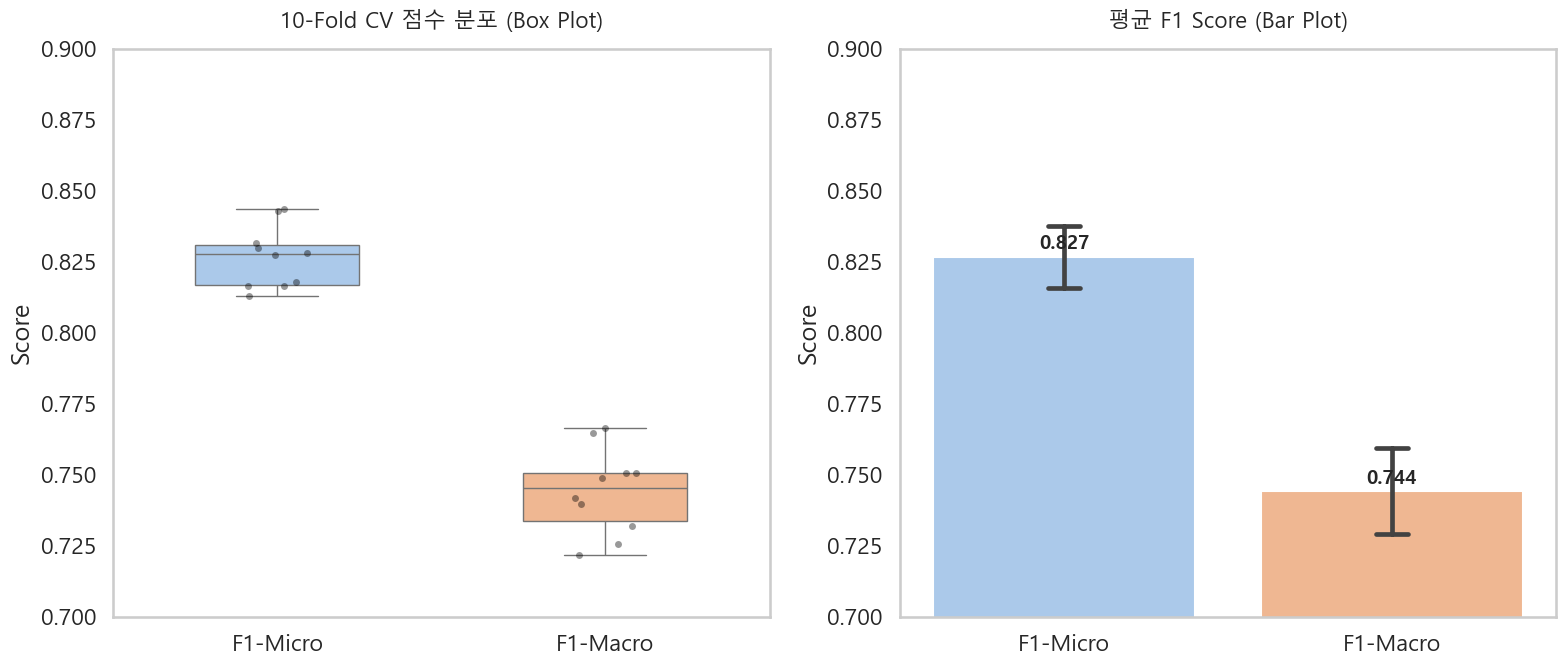

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -------------------------------------------------------
# 1. (가정) CV 결과 데이터 예시
# 실제 코드에서는 cv_scores_micro, cv_scores_macro 리스트를 사용하세요.
# -------------------------------------------------------
np.random.seed(42)
cv_scores_micro = np.random.normal(loc=0.82, scale=0.015, size=10) # 평균 0.82
cv_scores_macro = np.random.normal(loc=0.76, scale=0.02, size=10)  # 평균 0.76

# 데이터프레임 변환 (시각화를 위해 필수)
df_cv = pd.DataFrame({
    "F1-Micro": cv_scores_micro,
    "F1-Macro": cv_scores_macro
})

# Seaborn용 포맷으로 변경 (Melting)
df_melted = df_cv.melt(var_name="Metric", value_name="Score")

# -------------------------------------------------------
# 2. 그래프 그리기 설정을 위한 준비
# -------------------------------------------------------
# 스타일 설정 (흰 배경, 깔끔한 스타일)
sns.set_theme(style="whitegrid", context="talk", palette="pastel")
plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우 한글 폰트 설정 (맥은 AppleGothic)
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지

# 그림판 생성 (1행 2열로 두 가지 스타일 비교)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# -------------------------------------------------------
# [Style A] Box Plot (전문가용: 분포 확인)
# -------------------------------------------------------
sns.boxplot(
    data=df_melted,
    x="Metric",
    y="Score",
    ax=axes[0],
    width=0.5,
    palette=["#a1c9f4", "#ffb482"] # 파스텔 블루/오렌지
)
# 개별 Fold 점수를 점으로 찍어서 보여주기 (Strip plot)
sns.stripplot(
    data=df_melted,
    x="Metric",
    y="Score",
    color="black",
    alpha=0.4,
    ax=axes[0],
    jitter=True
)
axes[0].set_title("10-Fold CV 점수 분포 (Box Plot)", fontsize=16, pad=15)
axes[0].set_ylim(0.7, 0.9) # y축 범위는 데이터에 맞게 조절하세요
axes[0].set_xlabel("")

# -------------------------------------------------------
# [Style B] Bar Plot (발표용: 평균 강조)
# -------------------------------------------------------
barplot = sns.barplot(
    data=df_melted,
    x="Metric",
    y="Score",
    ax=axes[1],
    capsize=.1, # 에러바(표준편차) 머리 크기
    errorbar="sd", # 표준편차 표시
    palette=["#a1c9f4", "#ffb482"]
)

# 막대 위에 점수 숫자 쓰기
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), '.3f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center', va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points',
        fontsize=14,
        fontweight='bold'
    )

axes[1].set_title("평균 F1 Score (Bar Plot)", fontsize=16, pad=15)
axes[1].set_ylim(0.7, 0.9) # y축 범위 조절
axes[1].set_xlabel("")

plt.tight_layout()
axes[0].grid(False)
axes[1].grid(False)
plt.savefig("cv_result_graphs.png", dpi=300, bbox_inches='tight') # 고화질 저장
# plt.show() # 주피터 노트북이면 주석 해제

### 5-2. k-fold 검증

In [25]:
def build_tau_array(tag_names, config, default_th=0.5):
	thres = config.get("thresholds", {})
	tau = np.array([thres.get(tag, default_th) for tag in tag_names], dtype=float)

	return tau

def predict_with_thresholds_from_proba(proba, tag_names, config, default_th=0.5):
	thres = config.get("thresholds", {})
	y_pred = np.zeros_like(proba, dtype=np.uint8)

	for j, tag in enumerate(tag_names):
		t = thres.get(tag, default_th)
		y_pred[:, j] = (proba[:, j] >= t).astype(np.uint8)

	return y_pred

def predict_topk_from_proba(proba, k=2):
	n_samples, n_tags = proba.shape
	y_pred = np.zeros_like(proba, dtype=np.uint8)

	topk_idx = np.argsort(proba, axis=1)[:, -k:]  # (n_samples, k)
	for i in range(n_samples):
		y_pred[i, topk_idx[i]] = 1

	return y_pred

def predict_margin_top2_from_proba(proba, tau, k=2):
	n_samples, n_tags = proba.shape
	y_pred = np.zeros_like(proba, dtype=np.uint8)

	for i in range(n_samples):
		p = proba[i]  # (n_tags,)

		# margin score 계산
		s = np.zeros_like(p, dtype=float)
		above = p >= tau
		s[above] = (p[above] - tau[above]) / (1.0 - tau[above] + 1e-8)

		# margin > 0 후보
		candidates = np.where(s > 0)[0]

		if len(candidates) >= k:
			# 후보 안에서 margin 기준 top-k
			top_idx_in_cand = np.argsort(s[candidates])[-k:]
			top_tags = candidates[top_idx_in_cand]
		elif len(candidates) == 1 and k > 1:
			first = candidates[0]
			# 나머지는 proba 기준으로 채우기
			order = np.argsort(p)
			second = None
			for idx in order[::-1]:
				if idx != first:
					second = idx
					break
			if second is None:
				top_tags = np.array([first])
			else:
				top_tags = np.array([first, second])
		else:
			# 후보 0개 → proba 기준 top-k
			top_tags = np.argsort(p)[-k:]

		y_pred[i, top_tags] = 1

	return y_pred

In [26]:
kf = KFold(n_splits=10, shuffle=True, random_state=v2_config["random_state"])

all_true = []
all_pred_thresh = []   # 기존 threshold 방식
all_pred_top2 = []     # 방법 1
all_pred_margin2 = []  # 방법 2

tau_vec = build_tau_array(classification_label_column, v2_config)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_classification)):
	X_tr, X_val = X_classification.iloc[tr_idx], X_classification.iloc[val_idx]
	y_tr, y_val = y_classification.iloc[tr_idx], y_classification.iloc[val_idx]

	pipe_ovr = Pipeline([
		("clean", TextCleaner()),
		("tfidf", TfidfVectorizer(
			ngram_range=v2_config["tfidf"]["ngram_range"],
			min_df=v2_config["tfidf"]["min_df"],
			max_df=v2_config["tfidf"]["max_df"],
			vocabulary=vocabulary,
		)),
		("clf", OneVsRestClassifier(
			LogisticRegression(
				C=v2_config["logreg"]["C"],
				max_iter=v2_config["logreg"]["max_iter"],
				solver=v2_config["logreg"]["solver"],
				n_jobs=-1,
				class_weight=v2_config["logreg"]["class_weight"],
			),
			n_jobs=-1
		)),
	])

	pipe_ovr.fit(X_tr, y_tr)
	proba_val = pipe_ovr.predict_proba(X_val)

	# 1) 기존 threshold 기반 멀티레이블
	y_val_pred_thresh = predict_with_thresholds_from_proba(
		proba_val,
		classification_label_column,
		v2_config,
	)

	# 2) 단순 proba top-2
	y_val_pred_top2 = predict_topk_from_proba(
		proba_val,
		k=2,
	)

	# 3) margin + top-2
	y_val_pred_margin2 = predict_margin_top2_from_proba(
		proba_val,
		tau_vec,
		k=2,
	)

	all_true.append(y_val.to_numpy())
	all_pred_thresh.append(y_val_pred_thresh)
	all_pred_top2.append(y_val_pred_top2)
	all_pred_margin2.append(y_val_pred_margin2)

# 전체 스택
y_true_cv = np.vstack(all_true)
y_pred_thresh_cv = np.vstack(all_pred_thresh)
y_pred_top2_cv = np.vstack(all_pred_top2)
y_pred_margin2_cv = np.vstack(all_pred_margin2)

print("=== 기존 threshold 방식 ===")
print(classification_report(y_true_cv, y_pred_thresh_cv, target_names=classification_label_column, zero_division=0))

print("\n=== 단순 proba top-2 (방법 1) ===")
print(classification_report(y_true_cv, y_pred_top2_cv, target_names=classification_label_column, zero_division=0))

print("\n=== margin + top-2 (방법 2) ===")
print(classification_report(y_true_cv, y_pred_margin2_cv, target_names=classification_label_column, zero_division=0))

=== 기존 threshold 방식 ===
              precision    recall  f1-score   support

    activity       0.76      0.85      0.80       295
    children       0.87      0.66      0.75        79
     culture       0.83      0.91      0.87       316
        food       0.82      0.84      0.83       119
      nature       0.69      0.65      0.67        71
       night       0.64      0.70      0.67        50
      season       0.69      0.71      0.70        68

   micro avg       0.78      0.82      0.80       998
   macro avg       0.75      0.76      0.75       998
weighted avg       0.78      0.82      0.80       998
 samples avg       0.81      0.82      0.79       998


=== 단순 proba top-2 (방법 1) ===
              precision    recall  f1-score   support

    activity       0.82      0.77      0.80       295
    children       0.85      0.77      0.81        79
     culture       0.90      0.83      0.86       316
        food       0.83      0.87      0.85       119
      nature       0.58

========== 10-Fold CV : Method 2 (Margin + Top-2) ==========
Fold  |  Train F1  |   Val F1   | Diff (Tr-Val)
---------------------------------------------
  1   | 0.9211     | 0.8200     | 0.1011
  2   | 0.9200     | 0.8200     | 0.1000
  3   | 0.9144     | 0.8400     | 0.0744
  4   | 0.9156     | 0.8100     | 0.1056
  5   | 0.9133     | 0.8500     | 0.0633
  6   | 0.9233     | 0.8000     | 0.1233
  7   | 0.9156     | 0.7900     | 0.1256
  8   | 0.9167     | 0.8000     | 0.1167
  9   | 0.9167     | 0.7400     | 0.1767
 10   | 0.9111     | 0.7800     | 0.1311
---------------------------------------------

[Final Result]
Average Train F1 : 0.9168
Average Val F1   : 0.8050
Gap (Overfitting): 0.1118

=== Detailed Classification Report (Validation Aggregated) ===
              precision    recall  f1-score   support

    activity       0.81      0.81      0.81       295
    children       0.86      0.70      0.77        79
     culture       0.87      0.87      0.87       316
        food  

# 6. 내가 만든 가상의 축제 태그 예측

In [28]:
title = ["메타빌드 피자&파스타 축제", "한강 피크닉 버스킹 & 푸드트럭 페스티벌", "어린이 전통놀이 & 동화 콘서트", "봄 벚꽃 산책 & 유채꽃 정원 축제", "별빛 드론쇼 & 야간 플리마켓", "로컬푸드 & 전통음악 한마당", "숲속 어린이 생태캠프", "겨울 빛축제 & 크리스마스 야행"]

infotext = [
    """
    메타빌드 교육원에서 피자를 쏜다!
    교육팀장님이 사주시는 따끈한 피자와 파스타를 마음껏 즐겨 보세요.
    1층 스타벅스 카페에서 무료 커피도 증정합니다.
    현장에서는 어린이들을 위한 간식 코너와 음료도 준비되어 있습니다.
    참여한 어린이들을 대상으로는 추첨을 통해 푸짐한 상품을 드립니다.
    """,
    """
    한강 공원 잔디광장에서 열리는 피크닉 형식의 축제입니다. 한강 공원을 여유롭게 산책하고,
    방문객들은 돗자리를 펴고 버스킹 공연과 거리공연을 보면서 다양한 푸드트럭, 먹거리 부스, 디저트를 즐길 수 있습니다.
    현장에는 간단한 체험부스와 참여형 게임, 한강뷰 포토존도 마련되어 있어 친구, 연인과 함께 가볍게 놀기 좋습니다.
    """,
    """
    시립 도서관 앞 마당에서 열리는 어린이 대상 문화 축제입니다.
    아이들이 직접 참여하는 전통놀이, 민속놀이 체험과 함께,
    배우들이 동화를 연기하는 동화 콘서트 공연이 진행됩니다.
    가족단위 관람객이 대부분이며, 행사 후에는 참여한 아이들에게 작은 책 선물도 제공합니다.
    """,
    """
    강가 산책길과 언덕 정원을 따라 만개한 벚꽃과 유채꽃을 감상하는 봄꽃 축제입니다.
    방문객들은 천천히 산책을 즐기며 자연경관, 풍경을 사진으로 남길 수 있고,
    안내 해설과 함께 하는 작은 자연 생태 설명 프로그램도 운영됩니다.
    축제 기간 동안 지역 농가에서 가져온 화분과 꽃을 판매하는 코너도 마련됩니다.
    """,
    """
    도심 광장에서 열리는 야간 축제로, 하늘을 수놓는 드론쇼와 불꽃놀이가 메인 프로그램입니다.
    광장 주변에서는 시민들이 직접 참여하는 플리마켓, 프리마켓과
    음악에 맞춰 함께 움직이는 랜덤플레이댄스, 참여형 퍼포먼스가 진행됩니다.
    화려한 야간경관을 배경으로 사진을 찍을 수 있는 포토존도 운영됩니다.
    """,
    """
    지역 농가와 시장 상인이 참여하는 로컬푸드, 농특산물 먹거리 축제입니다.
    장터 한쪽에서는 국악 공연, 판소리, 전통춤이 펼쳐지고,
    다른 한쪽에서는 전통 음식과 막걸리, 전통주를 시음할 수 있는 푸드존이 운영됩니다.
    전통 공연을 감상하며 지역 특산물을 맛볼 수 있는 문화·미식 복합 행사입니다.
    """,
    """
    도시 근교 숲과 공원에서 열리는 1일 어린이 생태 체험 프로그램입니다.
    아이들은 숲 해설사와 함께 산책을 하며 곤충과 식물을 관찰하고,
    숲속 놀이터에서 민속놀이와 자연물을 활용한 체험프로그램에 참여합니다.
    가족과 함께 참여하는 형태로, 아이들에게 자연과 생태의 소중함을 알려주는 축제입니다.
    """,
    """
    도심 하천과 광장 일대를 LED 경관조명으로 장식한 겨울 시즌 빛축제입니다.
    연말 크리스마스 기간에 맞춰 운영되며,
    밤마다 야간경관 속에서 산책을 즐길 수 있는 야행 프로그램이 진행됩니다.
    일정 시간마다 작은 불꽃 쇼와 트리 점등식이 열려 연인과 가족 관람객이 많이 찾습니다.
    """
]

activity = [0, 1, 0, 0, 1, 0, 0, 0]
children = [1, 0, 1, 0, 0, 0, 1, 0]
culture =  [0, 0, 1, 0, 0, 1, 0, 0]
food =     [1, 1, 0, 0, 0, 1, 0, 0]
nature =   [0, 0, 0, 1, 0, 0, 1, 0]
night =    [0, 0, 0, 0, 1, 0, 0, 1]
season =   [0, 0, 0, 1, 0, 0, 0, 1]

df = pd.DataFrame({"title": title,
                   "infotext": infotext,
                   "activity": activity,
                   "children": children,
                   "culture": culture,
                   "food": food,
                   "nature": nature,
                   "night": night,
                   "season": season})
df

,title,infotext,activity,children,culture,food,nature,night,season
0,메타빌드 피자&파스타 축제,\n 메타빌드 교육원에서 피자를 쏜다!\n 교육팀장님이 사주시는 따끈한 ...,0,1,0,1,0,0,0
1,한강 피크닉 버스킹 & 푸드트럭 페스티벌,\n 한강 공원 잔디광장에서 열리는 피크닉 형식의 축제입니다. 한강 공원을 여...,1,0,0,1,0,0,0
2,어린이 전통놀이 & 동화 콘서트,\n 시립 도서관 앞 마당에서 열리는 어린이 대상 문화 축제입니다.\n ...,0,1,1,0,0,0,0
3,봄 벚꽃 산책 & 유채꽃 정원 축제,\n 강가 산책길과 언덕 정원을 따라 만개한 벚꽃과 유채꽃을 감상하는 봄꽃 축...,0,0,0,0,1,0,1
4,별빛 드론쇼 & 야간 플리마켓,"\n 도심 광장에서 열리는 야간 축제로, 하늘을 수놓는 드론쇼와 불꽃놀이가 메...",1,0,0,0,0,1,0
5,로컬푸드 & 전통음악 한마당,"\n 지역 농가와 시장 상인이 참여하는 로컬푸드, 농특산물 먹거리 축제입니다....",0,0,1,1,0,0,0
6,숲속 어린이 생태캠프,\n 도시 근교 숲과 공원에서 열리는 1일 어린이 생태 체험 프로그램입니다.\...,0,1,0,0,1,0,0
7,겨울 빛축제 & 크리스마스 야행,\n 도심 하천과 광장 일대를 LED 경관조명으로 장식한 겨울 시즌 빛축제입니...,0,0,0,0,0,1,1


In [20]:
X, y = df.infotext, df.drop(["title", "infotext"], axis=1)

y_proba = pipe_ovr.predict_proba(X)

top_k = 2
top2_idx = np.argsort(y_proba, axis=1)[:, -top_k:]
y_pred = np.zeros_like(y_proba, dtype=np.uint8)
for i, idxs in enumerate(top2_idx):
	y_pred[i, idxs] = 1

print(classification_report(y, y_pred, target_names=classification_label_column))

              precision    recall  f1-score   support

    activity       1.00      1.00      1.00         2
    children       1.00      1.00      1.00         3
     culture       1.00      1.00      1.00         2
        food       1.00      1.00      1.00         3
      nature       1.00      1.00      1.00         2
       night       1.00      1.00      1.00         2
      season       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16



# 8. 모델, 임계값, 단어장 저장

In [21]:
os.makedirs("model", exist_ok=True)
joblib.dump(pipe_ovr, "model/pipe_ovr_v1.pkl")

['model/pipe_ovr_v1.pkl']

In [22]:
tag_name = ["activity", "children", "culture", "food", "nature", "night", "season"]
with open("model/tag_name_v1.json", "w", encoding="utf-8") as f:
	json.dump(tag_name, f, ensure_ascii=False, indent="\t")

In [23]:
with open("model/v1_config.json", "w", encoding="utf-8") as f:
	json.dump(v2_config, f, ensure_ascii=False, indent="\t")

In [24]:
tag_vocab = {
	"activity": {
		"strong": [
			"거리공연", "길놀이", "놀이터", "눈썰매", "드론", "드론쇼", "마임", "물놀이", "민속놀이", "불꽃놀이",
            "빙어낚시", "산책", "쇼", "썰매", "아트마켓", "얼음썰매", "요가", "윷놀이", "참여프로그램",
            "랜덤플레이댄스", "체험", "체험부스", "체험존", "체험프로그램", "체험행사", "춤", "카약", "캠핑", "탐방",
            "투어", "파티", "퍼레이드", "풀장", "프리마켓", "플래시몹", "플리마켓", "참여형",
		],
		"weak": [
			"개막공연", "개막행사", "게임", "경연", "공모전", "공방", "부대행사", "사생대회", "스탬프",
            "시식", "시연", "시음", "연출", "워크숍", "즐길거리", "참가", "챌린지", "체험장", "초청공연",
            "촬영", "축하공연", "출연", "콘테스트", "토크쇼", "특별공연", "패션쇼", "포토존", "피크닉", "피크닉존", "야시장",
		]
	},
	"children": {
		"strong": [
			"가족", "가족단위", "그림책", "놀이터", "눈썰매", "도서관", "민속놀이", "아이들", "어린이", "어린이날",
            "얼음썰매", "윷놀이", "청소년", "피크닉", "피크닉존"
		],
		"weak": [
			"가정", "꿈", "나들이", "놀이", "인생네컷", "책", "키링"
		]
	},
	"culture": {
		"strong": [
			"공연", "공예", "공예품", "국가유산", "군악대", "궁중", "그림책", "노래", "노래자랑",
            "다문화", "달집태우기", "도서관", "독서", "마임", "무형유산", "문학", "문화", "문화공연", "문화관광축제",
            "문화예술", "문화예술공연", "문화유산", "문화제", "문화체험", "문화축제", "문화행사", "뮤지션", "뮤지컬", "민속놀이",
			"박물관", "밴드", "버스킹", "버스킹공연", "세계유산", "소리", "아리랑", "역사", "예술", "예술인",
            "오케스트라", "왕실", "웹툰", "유네스코", "재즈", "전시관", "전시회", "전통", "전통놀이", "전통문화",
            "정월대보름", "조선시대", "지역예술인", "책", "춤", "캘리그라피", "콘서트", "크리스마스", "클래식", "트로트",
            "판소리", "한글", "한복", "합창단", "힙합", "농악",
		],
		"weak": [
			"그림", "근대", "도깨비", "문화적", "미디어", "사생대회", "사진", "시간여행", "아티스트", "역사적",
            "영상", "예술적", "작품", "정취", "출판사", "트리", "향수", "향연", "전통주"
		]
	},
	"food": {
		"strong": [
			"간식", "건어물", "고구마", "고등어", "고로쇠", "곶감", "김밥", "농산물", "농특산물", "디저트",
            "딸기", "로컬푸드", "막걸리", "맛", "맛집", "맥주", "먹거리", "먹거리부스", "미식", "바지락",
			"분식", "비빔밥", "수산물", "수제맥주", "야시장", "요리", "음료", "음식", "장어", "전통주",
            "치즈", "커피", "토마토", "특산물", "특산품", "푸드존", "푸드트럭", "푸드트럭존", "한우"
		],
		"weak": [
			"달콤", "마켓", "상품", "장터", "저잣거리", "전통시장", "카페"
		]
	},
	"nature": {
		"strong": [
			"가을꽃", "갯골", "갯벌", "공원", "꽃", "나비", "무궁화", "보리밭", "산", "산수유",
            "산책", "산책길", "생태", "수국", "수선화", "숲", "억새", "유채꽃", "자연", "자연경관",
            "정원", "풍경", "해변", "국화"
		],
		"weak": [
			"나들이", "노을", "물결", "물놀이", "빙어낚시", "웰니스", "잔디광장", "친환경", "하늘"
		]
	},
	"night": {
		"strong": [
			"경관조명", "달집태우기", "드론쇼", "라이트쇼", "밤", "별", "별빛", "불꽃", "불꽃놀이", "불꽃쇼",
            "야간경관", "야경", "야시장", "야행", "유등", "전야제", "정월대보름", "미디어파사드", "파사드",
		],
		"weak": [
			"달빛", "라이트", "야간", "저녁", "점등식"
		]
	},
	"season": {
		"strong": [
			"가을", "가을꽃", "겨울", "겨울철", "계절", "단오", "벚꽃", "봄", "봄꽃", "봄날",
            "새해", "여름", "유채꽃", "정월대보름", "크리스마스", "풍년"
		],
		"weak": [
			"딸기", "어린이날", "얼음썰매"
		]
	}
}

with open("model/vocabulary_v1.json", "w", encoding="utf-8") as f:
	json.dump(tag_vocab, f, ensure_ascii=False, indent="\t")

In [25]:
with open("model/combined_scores_v1.json", "w", encoding="utf-8") as f:
	json.dump(combined_scores, f, ensure_ascii=False, indent="\t")